In [3]:
#This script pulls in WHO datasets for New cases and new deaths from COVID-19, builds and tests several predictive models, and subsequently makes predictions for mortality rates. A comparison is done between lockdown and social distancing approaches to the pandemic using the best model.

# author = 'Dr Adaeze Nwobodo' email = 'AdaezeNwobodo@gmail.com'

#import library packages {caret/Dplyr/lubridate/mgcv/purrr/ranger/rpart/rpart.plot/sigr/tidyselect/tidyverse/wrapr/base/broom/cluster/datasets/ellipsis/ggplot2/graphics/grDevices/highr/lattice/maggritr/methods/nlme/ readr/readxl/renv/stats/stringr/tibble/tidyr/utils}

In [4]:
# DEFINE HELPER FUNCTIONS 

In [5]:
# 1
load_file <- function(filename) {
    #loads csv into dataframe
    return (read_csv(filename))
}
    
print(load_file)

function(filename) {
    #loads csv into dataframe
    return (read_csv(filename))
}


In [6]:
#Import libraries 
library(dplyr) 
library(ggplot2) 
library(tidyr) 
library(caret) 
library(lubridate) 
library(purrr)
library(mgcv)
library(rpart)
install.packages("sigr"); library(sigr)
library(tidyverse)
library(tidyselect)
library(utils)
library(base)
library(broom)
library(cluster)
library(ellipsis)
library(graphics)
library(grDevices)
library(highr)
library(lattice)
library(methods)
library(nlme)
library(readr)
library(readxl)
library(stats)
library(stringr)
install.packages("vtreat"); library(vtreat)
library(tibble)
install.packages("xgboost"); library(xgboost)
library(randomForest)
library(magrittr)
install.packages("Metrics"); library(Metrics)
install.packages("zoo"); library(xts)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: lattice

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date


Attaching package: 'purrr'

The following object is masked from 'package:caret':

    lift

Loading required package: nlme

Attaching package: 'nlme'

The following object is masked from 'package:dplyr':

    collapse

This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  3.0.5     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyver

In [9]:
WHO_COVID19 <- load_file("WHO-COVID-19-global-data.csv")

Parsed with column specification:
cols(
  Date_reported = col_character(),
  Country_code = col_character(),
  Country = col_character(),
  WHO_region = col_character(),
  New_cases = col_double(),
  Cumulative_cases = col_double(),
  New_deaths = col_double(),
  Cumulative_deaths = col_double()
)


In [8]:
head(WHO_COVID19, n = 5)

Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
03/01/2020,AF,Afghanistan,EMRO,0,0,0,0
04/01/2020,AF,Afghanistan,EMRO,0,0,0,0
05/01/2020,AF,Afghanistan,EMRO,0,0,0,0
06/01/2020,AF,Afghanistan,EMRO,0,0,0,0
07/01/2020,AF,Afghanistan,EMRO,0,0,0,0


In [10]:
# Structure of the COVID datasets
str(WHO_COVID19)

tibble [71,675 x 8] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Date_reported    : chr [1:71675] "03/01/2020" "04/01/2020" "05/01/2020" "06/01/2020" ...
 $ Country_code     : chr [1:71675] "AF" "AF" "AF" "AF" ...
 $ Country          : chr [1:71675] "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ WHO_region       : chr [1:71675] "EMRO" "EMRO" "EMRO" "EMRO" ...
 $ New_cases        : num [1:71675] 0 0 0 0 0 0 0 0 0 0 ...
 $ Cumulative_cases : num [1:71675] 0 0 0 0 0 0 0 0 0 0 ...
 $ New_deaths       : num [1:71675] 0 0 0 0 0 0 0 0 0 0 ...
 $ Cumulative_deaths: num [1:71675] 0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, "spec")=
  .. cols(
  ..   Date_reported = col_character(),
  ..   Country_code = col_character(),
  ..   Country = col_character(),
  ..   WHO_region = col_character(),
  ..   New_cases = col_double(),
  ..   Cumulative_cases = col_double(),
  ..   New_deaths = col_double(),
  ..   Cumulative_deaths = col_double()
  .. )


In [11]:
#Class of dates column
class(WHO_COVID19$Date_reported)

[1] "character"

In [12]:
#Filter out UK datasets 
WHO_COVID19_UK <- WHO_COVID19 %>%
    filter(Country == "The United Kingdom")
head(WHO_COVID19_UK)

Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
03/01/2020,GB,The United Kingdom,EURO,0,0,0,0
04/01/2020,GB,The United Kingdom,EURO,0,0,0,0
05/01/2020,GB,The United Kingdom,EURO,0,0,0,0
06/01/2020,GB,The United Kingdom,EURO,0,0,0,0
07/01/2020,GB,The United Kingdom,EURO,0,0,0,0
08/01/2020,GB,The United Kingdom,EURO,0,0,0,0


In [13]:
#Remove 3 columns - "Country_code", "Country" and "WHO_region"
WHO_COVID19_UK <- WHO_COVID19_UK %>%
    select(-Country_code, -Country, -WHO_region)

In [14]:
#View dataset
head(WHO_COVID19_UK, n = 5)

Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
03/01/2020,0,0,0,0
04/01/2020,0,0,0,0
05/01/2020,0,0,0,0
06/01/2020,0,0,0,0
07/01/2020,0,0,0,0


In [15]:
# Convert Date_reported column to time-based column (to convert to xts object)
WHO_COVID19_UK$Date_reported <- as.Date(WHO_COVID19_UK$Date_reported)

In [16]:
#Convert WHO_COVID19_UK to an xts object
WHO_COVID19_UK_xts <- as.xts(WHO_COVID19_UK[ , -1], order.by = WHO_COVID19_UK$Date_reported)

In [17]:
#Check the class of WHO_COVID19_UK_xts
class(WHO_COVID19_UK_xts)

[1] "xts" "zoo"

In [18]:
#Examine first 5 lines of WHO_COVID19_UK_xts
head(WHO_COVID19_UK_xts, n = 5)

           New_cases Cumulative_cases New_deaths Cumulative_deaths
0001-02-20         2                2          0                 0
0001-03-20        12               42          0                 0
0001-04-20      4273            33954        403              2453
0001-05-20      5446           172596        634             26683
0001-06-20      1125           255519         60             37445

In [21]:
#EXPLORATION OF THE WHO_COVID19_UK_xts DATA

In [23]:
#Identify the periodicity of WHO_COVID19_UK_xts
periodicity(WHO_COVID19_UK_xts)

Monthly periodicity from 0001-02-20 to 0031-10-20 

In [24]:
#Number of periods in WHO_COVID19_UK_xts
ndays(WHO_COVID19_UK_xts)

[1] 305

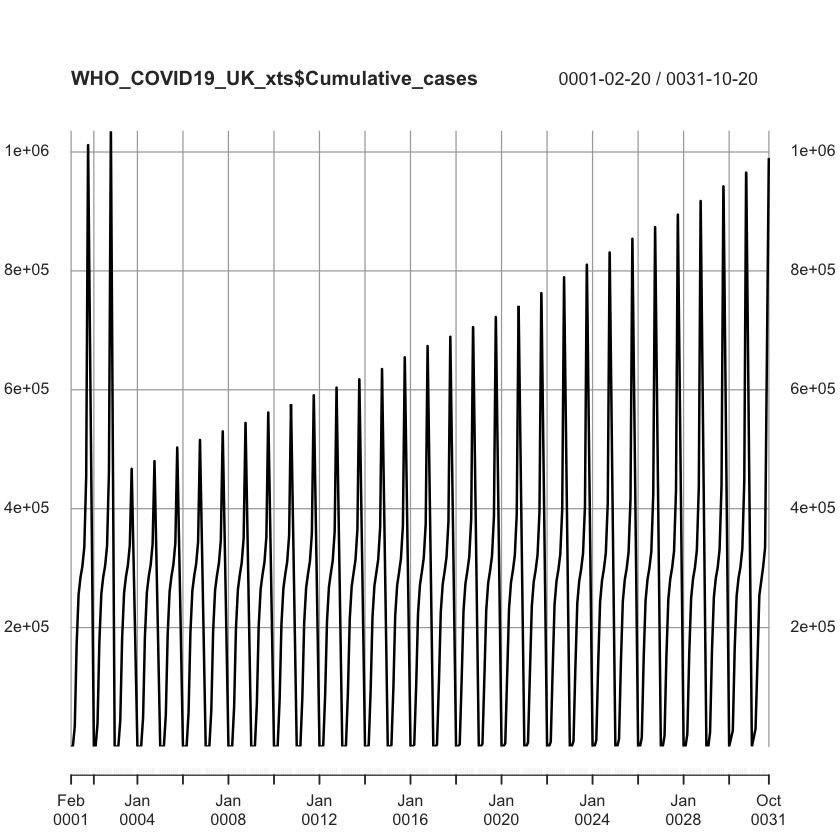

In [25]:
#VISUALISATION OF THE WHO_COVID19_UK_xts DATA
plot.xts(WHO_COVID19_UK_xts$Cumulative_cases)

In [26]:
#Calculate percentage of COVID cases contracted each month
WHO_COVID19_UK_xts$pct_new <- (WHO_COVID19_UK_xts$New_cases / WHO_COVID19_UK_xts$Cumulative_cases) * 100

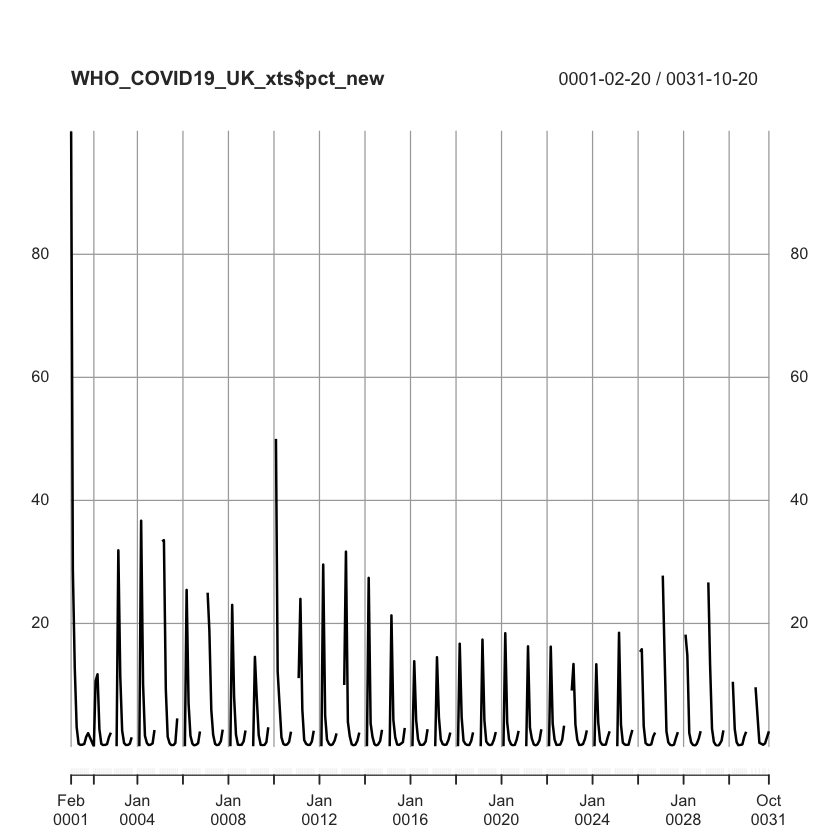

In [27]:
#Plot/view the percentage new COVID cases over time
plot.xts(WHO_COVID19_UK_xts$pct_new)

In [28]:
#Save xts object to RDS file
saveRDS(object = WHO_COVID19_UK_xts, file = "WHO_COVID19_UK_xts.rds")

#Read in data from the rds file
WHO_COVID19_UK_xts2 <- readRDS("WHO_COVID19_UK_xts.rds")

#Check class of new xts2 object
class(WHO_COVID19_UK_xts2)

#Examine first 5 rows of new xts2 object 
head(WHO_COVID19_UK_xts2, n = 5)

[1] "xts" "zoo"

           New_cases Cumulative_cases New_deaths Cumulative_deaths     pct_new
0001-02-20         2                2          0                 0 100.0000000
0001-03-20        12               42          0                 0  28.5714286
0001-04-20      4273            33954        403              2453  12.5846734
0001-05-20      5446           172596        634             26683   3.1553454
0001-06-20      1125           255519         60             37445   0.4402804

In [29]:
# Export xts object to csv file 
write.zoo(WHO_COVID19_UK_xts, file = "WHO_COVID19_UK_xts.csv", sep = ",")

#Open saved object using read.zoo
COVID19_xts2 <- read.zoo("WHO_COVID19_UK_xts.csv", sep = ",", FUN = as.Date, header = TRUE, index.column = 1)

#Encode new object back into xts
WHO_COVID19_UK_xts2 <- as.xts(COVID19_xts2)

#Examine first 5 rows of new xts2 object
head(WHO_COVID19_UK_xts2, n = 5)

           New_cases Cumulative_cases New_deaths Cumulative_deaths     pct_new
0001-02-20         2                2          0                 0 100.0000000
0001-03-20        12               42          0                 0  28.5714286
0001-04-20      4273            33954        403              2453  12.5846734
0001-05-20      5446           172596        634             26683   3.1553454
0001-06-20      1125           255519         60             37445   0.4402804

In [30]:
#Confirm sampling start and end functions
start(WHO_COVID19_UK_xts) #time index of first observation 

end(WHO_COVID19_UK_xts) #time index of last observation 

#Confirm sampling frequency function - number of observations made each day
frequency(WHO_COVID19_UK_xts)

#Confirm deltat function - the fixed time interval between observations (24/24)day
deltat(WHO_COVID19_UK_xts)


[1] "0001-02-20"

[1] "0031-10-20"

[1] 1

[1] 1

In [31]:
is.ts(WHO_COVID19_UK_xts) #check whether a time series object or not

[1] FALSE

In [32]:
COVID19UK_timeseries <- ts(WHO_COVID19_UK_xts) #convert vector into time series obect 

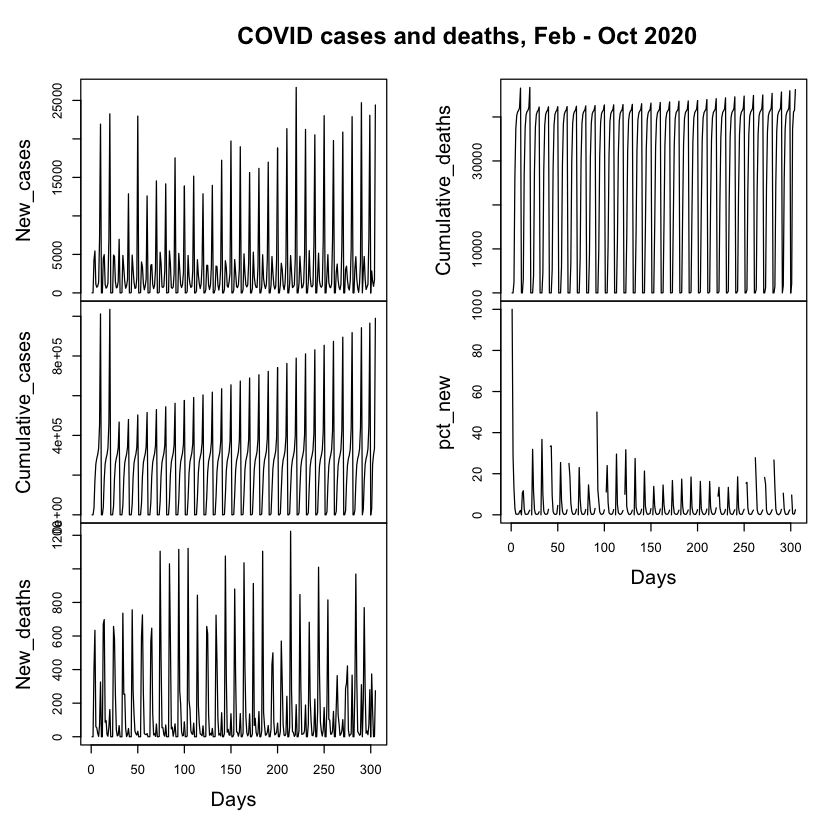

In [43]:
plot(COVID19UK_timeseries, xlab = "Days", main = "COVID cases and deaths, Feb - Oct 2020") #plot of time series data

In [36]:
is.ts(COVID19UK_timeseries) #datasets converted into timeseries objects

[1] TRUE

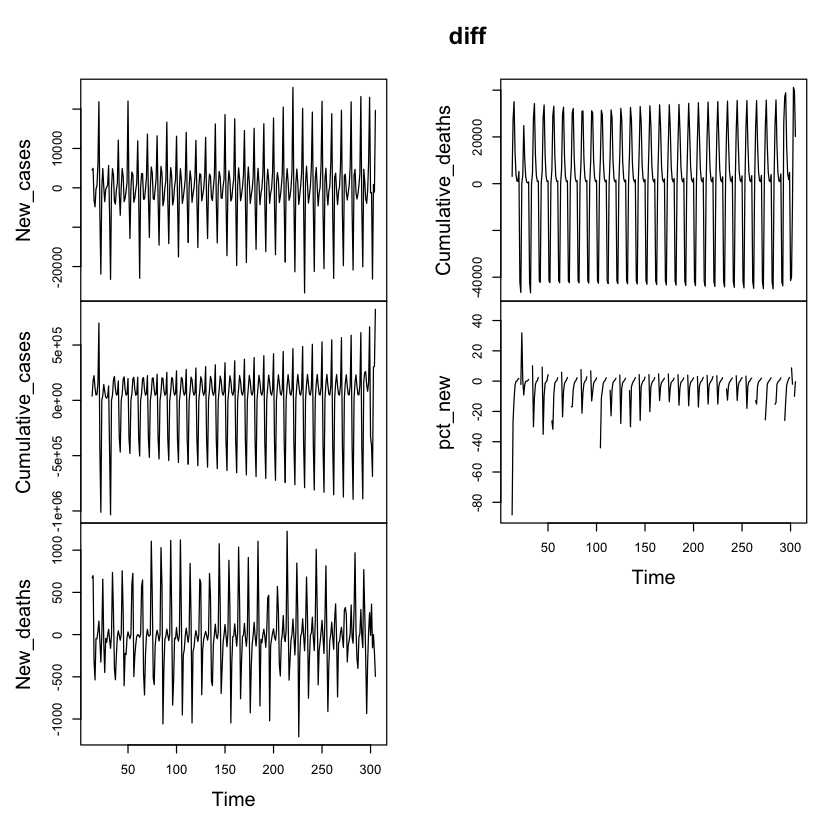

In [49]:
diff <- diff(COVID19UK_timeseries, lag = 12) #difference the data to remove the long-term trend (i.e. the seasonal volatility - and focus on the change from one period to another.)

plot(diff)

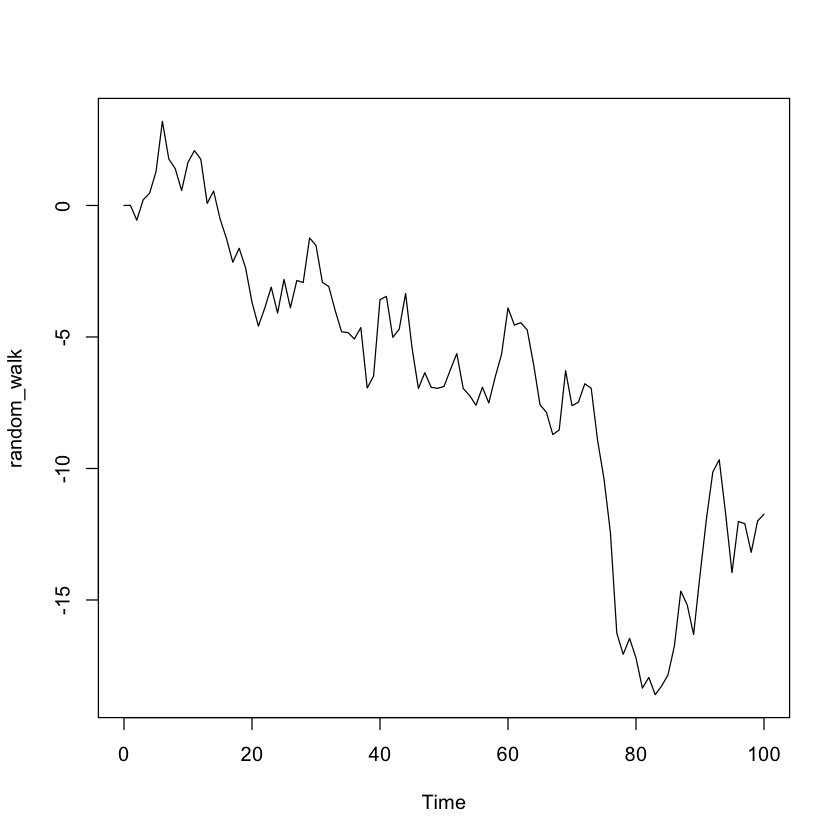

In [53]:
#Generate a RW model using arima.sim
random_walk_drift <- arima.sim(model = list(order = c(0, 1, 0)), n = 100)

#Plot random_walk
ts.plot(random_walk)

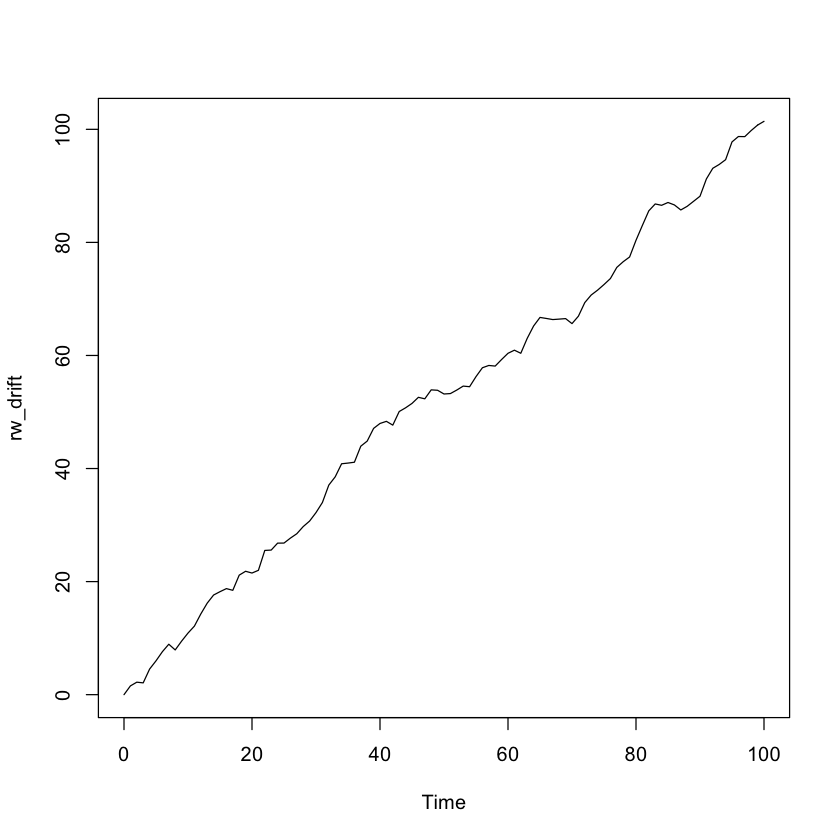

In [55]:
#Simulating same random walk model with drigt
rw_drift <- arima.sim(model = list(order = c(0, 1, 0)), n = 100, mean = 1)

#Plot of rw_drift
ts.plot(rw_drift)

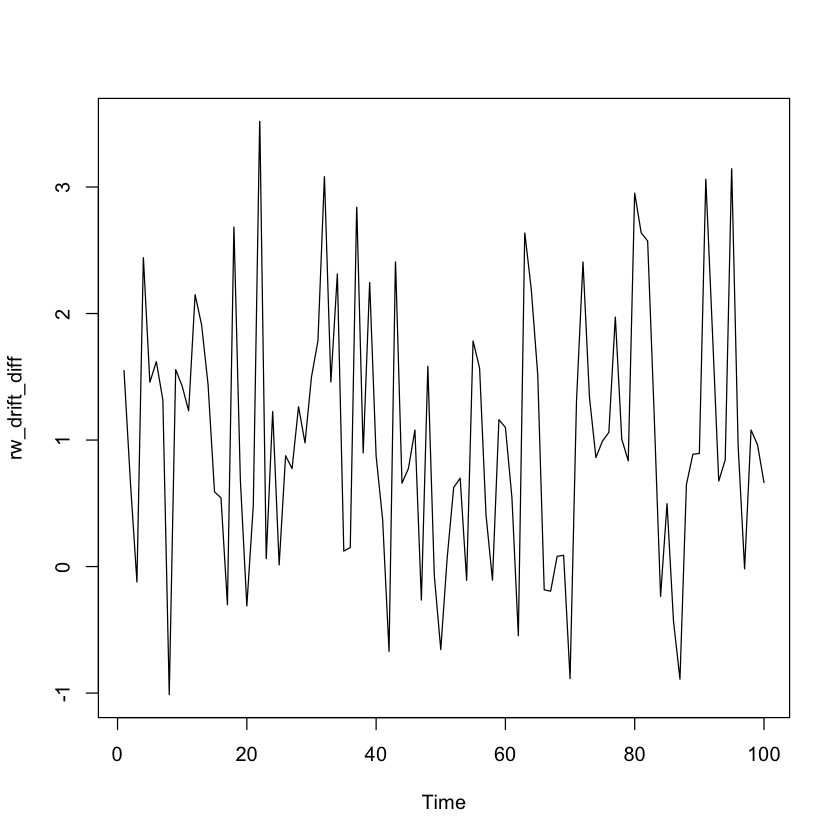

In [56]:
#Calculation of first difference of rw_drift data
rw_drift_diff <- diff(rw_drift)

#Plot differenced data - transforms back into white noise regardles of presence of long-term drift seen above
ts.plot(rw_drift_diff)